<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Load Dataset</h2>

In [2]:
df = pd.read_csv(r"C:\Users\Anuj\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<h2>Data Cleaning</h2>

In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df.isnull().count()

customerID          7043
gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
tenure              7043
PhoneService        7043
MultipleLines       7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7043
Churn               7043
dtype: int64

In [5]:
df.drop("customerID", axis=1, inplace=True)

In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [7]:
df.dropna(inplace=True)

<h2>Feature Engineering</h2>

In [8]:
for col in df.select_dtypes(include='object').columns:
    le=LabelEncoder()
    df[col]=le.fit_transform(df[col])

<h4>Splitting Data</h4>

In [9]:
X = df.drop("Churn",axis=1)
y = df["Churn"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<h4>Handle Class Imbalance</h4>

In [11]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

<h2>Feature Scaling</h2>

In [12]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

<h2>Logistic Regression</h2>

In [13]:
model_lr = LogisticRegression(
    class_weight={0:1, 1:5}, 
    max_iter=1000
)


model_lr.fit(X_train_sm, y_train_sm)
y_pred = model_lr.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.48      0.64      1033
           1       0.40      0.94      0.56       374

    accuracy                           0.60      1407
   macro avg       0.68      0.71      0.60      1407
weighted avg       0.81      0.60      0.62      1407



In [15]:
def churn_cost(y_true, y_pred):
    cost = 0
    for actual, pred in zip(y_true, y_pred):
        if actual == 1 and pred == 0:
            cost += 5000 # Missed churner
        elif actual == 0 and pred == 1:
            cost += 1000 # Wrong alarm
    return cost


print("Total Business Cost:", churn_cost(y_test, y_pred))

Total Business Cost: 653000


<h2>Random Forest</h2>

In [16]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight={0:1, 1:5},
    random_state=42
)


rf.fit(X_train_sm, y_train_sm)
rf_pred = rf.predict(X_test)


print(classification_report(y_test, rf_pred))
print("Business Cost:", churn_cost(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.58      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

Business Cost: 953000


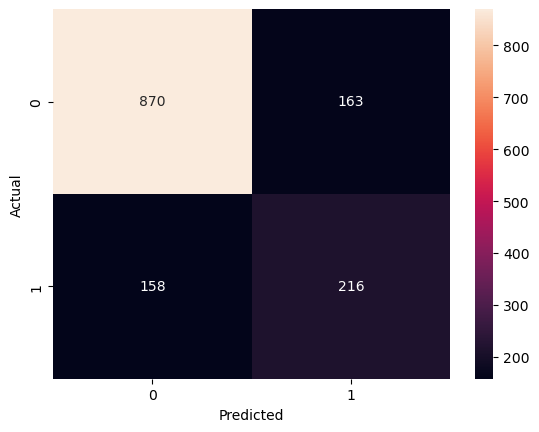

In [17]:
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

Contract           0.157957
TotalCharges       0.150358
MonthlyCharges     0.147452
tenure             0.131053
OnlineSecurity     0.059358
TechSupport        0.052782
PaymentMethod      0.046882
InternetService    0.034838
Dependents         0.031428
OnlineBackup       0.025804
dtype: float64

<h2>XGBoost</h2>

In [29]:
pos = sum(y_train == 1)
neg = sum(y_train == 0)


scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
n_estimators=300,
max_depth=6,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
scale_pos_weight=scale_pos_weight * 2, # cost-sensitive tuning
objective="binary:logistic",
eval_metric="logloss",
random_state=42
)


xgb_model.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
xgb_pred = xgb_model.predict(X_test)


print(classification_report(y_test, xgb_pred))
print("Business Cost:", churn_cost(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.66      0.77      1033
           1       0.46      0.80      0.59       374

    accuracy                           0.70      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.79      0.70      0.72      1407

Business Cost: 717000


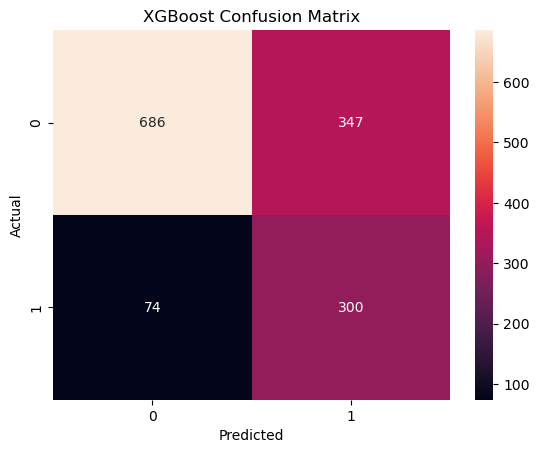

In [31]:
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

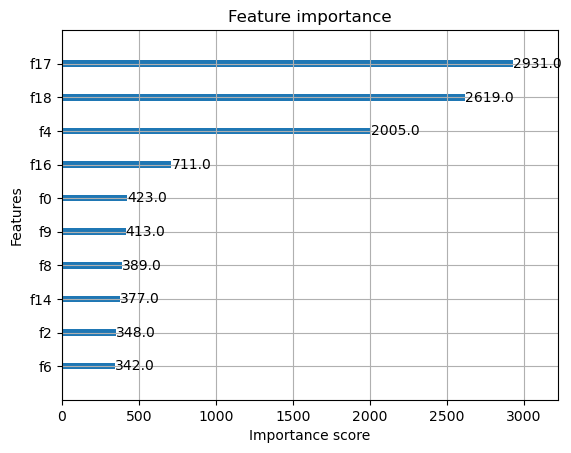

In [32]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

<h4>XGBoost After Optimization</h4>

In [34]:
y_prob = xgb_model.predict_proba(X_test)[:, 1]


thresholds = np.arange(0.2, 0.8, 0.01)
costs = []


for t in thresholds:
    y_custom = (y_prob >= t).astype(int)
    costs.append(churn_cost(y_test, y_custom))


best_threshold = thresholds[np.argmin(costs)]
best_threshold

np.float64(0.2)

In [35]:
y_final = (y_prob >= best_threshold).astype(int)
print("Optimized Business Cost:", churn_cost(y_test, y_final))

Optimized Business Cost: 676000


<h2>Conclusion</h2>

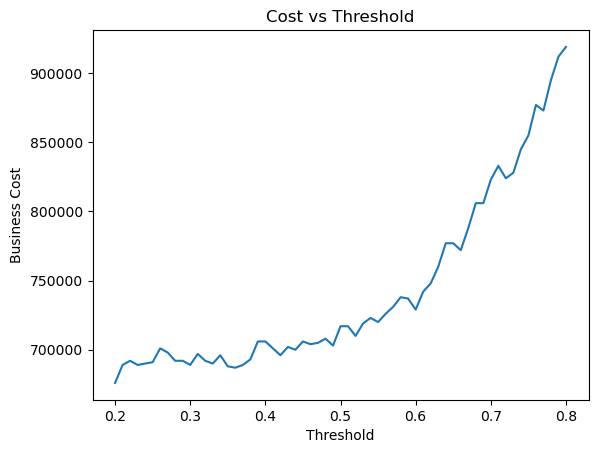

In [36]:
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Cost vs Threshold")
plt.show()

In [37]:
results = pd.DataFrame({
"Model": ["Logistic Regression", "Random Forest", "XGBoost"],
"Business Cost": [
churn_cost(y_test, y_pred),
churn_cost(y_test, rf_pred),
churn_cost(y_test, y_final)
]
})


results

,Model,Business Cost
0,Logistic Regression,653000
1,Random Forest,953000
2,XGBoost,676000


In [38]:
pd.DataFrame({
"Feature": X.columns,
"Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(10)

,Feature,Importance
14,Contract,0.385702
11,TechSupport,0.086432
8,OnlineSecurity,0.078559
7,InternetService,0.061596
3,Dependents,0.041186
5,PhoneService,0.035435
9,OnlineBackup,0.033636
17,MonthlyCharges,0.028768
2,Partner,0.027863
4,tenure,0.027180
